### Создано в кооперации с Yury Kanygin, Yaroslav Murzaev, Olga Gribova and Pastushkov Sergey, 
### а так же с помощью сайта  https://python-scripts.com/build-neural-network

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy import random
import numpy as np

#### Задаем параметры NN

In [2]:
input_size = 784       # Размеры изображения = 28 x 28 = 784
hidden_size = 50        # Количество узлов на скрытом слое
num_classes = 10       # Число классов на выходе. В этом случае от 0 до 9
num_epochs = 5         # Количество тренировок всего набора данных
batch_size = 100       # Размер входных данных для одной итерации
learning_rate = 0.001  # Скорость конвергенции

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = 13, 13

#### Загрузка датасета MNIST

In [4]:
train_dataset = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
 
test_dataset = dsets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

Processing...
Done!


In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
 
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

#### Создание нейронной сети

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Наследуемый родительским классом nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1й связанный слой: 784 (данные входа) -> 50 (скрытый узел)
        self.relu = nn.ReLU()                          # Нелинейный слой ReLU max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2й связанный слой: 50 (скрытый узел) -> 10 (класс вывода)
    
    def forward(self, x):                              # Передний пропуск: складывание каждого слоя вместе
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
net = Net(input_size, hidden_size, num_classes)

#### Задаем функцию потерь и оптимизатор

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Text(0,0.5,'loss')

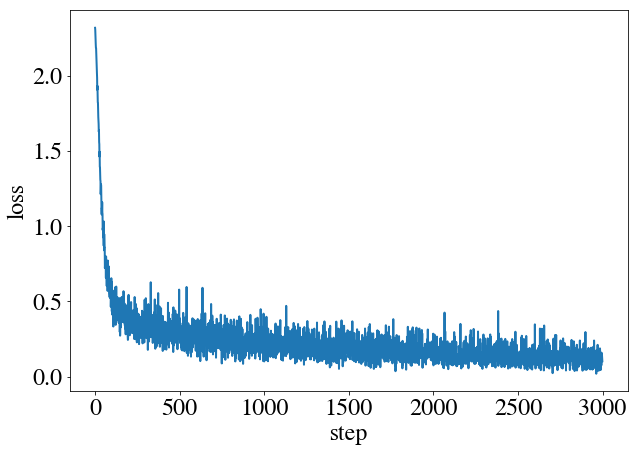

In [9]:
los = []
#step = []
#k = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Загрузка партии изображений с индексом, данными, классом
        images = Variable(images.view(-1, 28*28))         # Конвертация тензора в переменную: изменяем изображение с вектора, размером 784 на матрицу 28 x 28
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Инициализация скрытых масс до нулей
        outputs = net(images)                             # Передний пропуск: определение выходного класса, данного изображения
        loss = criterion(outputs, labels)                 # Определение потерь: разница между выходным классом и предварительно заданной меткой
        loss.backward()                                   # Обратный проход: определение параметра weight
        optimizer.step()                                  # Оптимизатор: обновление параметров веса в скрытых узлах
        los.append(loss.data.numpy())
        
plt.figure(figsize=(10, 7))
plt.plot(los)
plt.xlabel("step")
plt.ylabel("loss")

In [10]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Выбор лучшего класса из выходных данных: класс с лучшим счетом
    total += labels.size(0)                    # Увеличиваем суммарный счет
    correct += (predicted == labels).sum()     # Увеличиваем корректный счет
 
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 96 %


In [11]:
torch.save(net.state_dict(), 'fnn_model.pkl')

#### Исследуем влияение шума на скорость обучения нейросети.

In [12]:
def gauss(x, variance):
    noize_normal = np.random.normal(20, variance, size = np.array(x).shape)
    np_to_image = np.array(x) + np.abs(noize_normal)
    np_expand_dims = np.expand_dims(np_to_image, axis=2)
    return np.uint8(np_expand_dims)

In [13]:
train_noised_dataset = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: gauss(x, 50)) ,
            transforms.ToPILImage() ,
            transforms.ToTensor()
        ]),
    download=True
)
 
test_dataset = dsets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

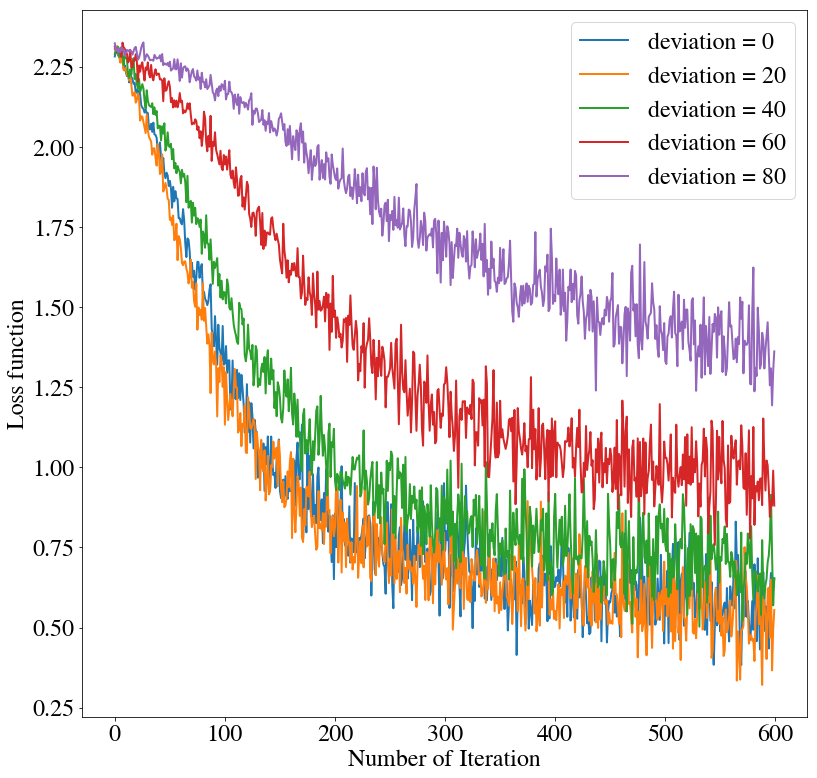

In [14]:
plt.xlabel('Number of Iteration')
plt.ylabel('Loss function')
for variance in np.arange(0, 100, 20):
    
    train_noised_dataset = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: gauss(x, variance)) ,
            transforms.ToPILImage() ,
            transforms.ToTensor()
        ]),
    download=True
    )
    
    train_noised_loader = torch.utils.data.DataLoader(
    dataset=train_noised_dataset,
    batch_size=batch_size,
    shuffle=True
    )
    
    net = Net(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    history = []
    for i, (images_train, labels_train) in enumerate(train_noised_loader):   # Загрузка партии изображений с индексом, данными, классом
        images_train = Variable(images_train.view(-1, 28*28))         # Конвертация тензора в переменную: изменяем изображение с вектора, размером 784 на матрицу 28 x 28
        labels_train = Variable(labels_train)

        optimizer.zero_grad()                             # Инициализация скрытых масс до нулей
        outputs = net(images_train)                             # Передний пропуск: определение выходного класса, данного изображения
        loss = criterion(outputs, labels_train)                 # Определение потерь: разница между выходным классом и предварительно заданной меткой
        loss.backward()                                   # Обратный проход: определение параметра weight
        optimizer.step()                                  # Оптимизатор: обновление параметров веса в скрытых узлах
        history.append(loss.data.numpy())

    plt.plot(history, label = 'deviation = %s' % variance)
plt.legend()
plt.show()